In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 60
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

Day  wind_10m  specific_humidity     LW_down   SW_down  rainfall  \
7305  1/1/1999  4.987515           0.891843  183.786092  1.120906  0.700735   
7306  1/2/1999  5.075952           0.905535  183.851814  1.193514  0.712730   
7307  1/3/1999  4.931520           0.911672  184.426913  1.263909  0.677339   
7308  1/4/1999  4.761644           0.911301  187.528326  1.269229  0.824016   
7309  1/5/1999  4.739850           0.901353  187.326709  1.552208  0.926681   

      snowfall   sosaline         sst         t2m  surface_pressure  \
7305  0.501109  33.316996  273.467869  250.884060        985.112721   
7306  0.482221  33.316996  273.453826  250.359328        984.092282   
7307  0.480718  33.316996  273.454385  250.327500        982.300080   
7308  0.697950  33.316996  273.459797  249.905730        983.250565   
7309  0.835868  33.316996  273.463975  250.254873        984.247389   

      sea_ice_extent  
7305        13823248  
7306        13885522  
7307        13884279  
7308        13912624  
7309        13890148

In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

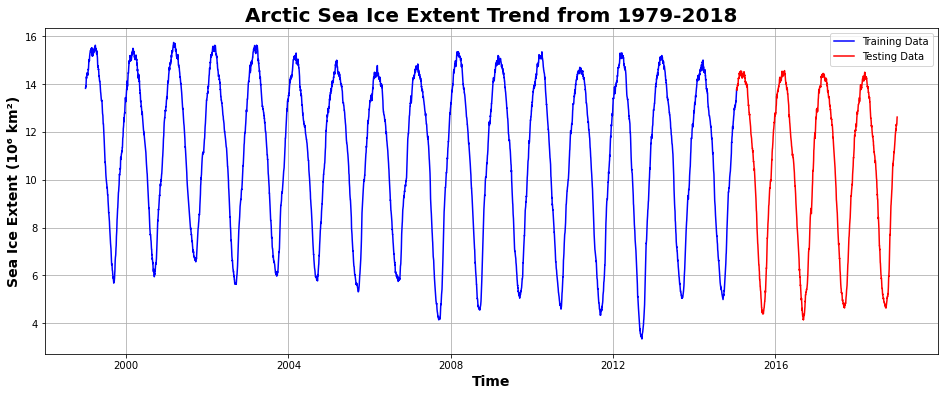

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,729
Trainable params: 121,729
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.1165 - mse: 0.0346

82/82 [==============================] - 9s 21ms/step - loss: 0.0346 - mae: 0.1165 - mse: 0.0346 - val_loss: 0.0011 - val_mae: 0.0268 - val_mse: 0.0011
Epoch 2/100
81/82 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0550 - mse: 0.0048

82/82 [==============================] - 1s 9ms/step - loss: 0.0048 - mae: 0.0550 - mse: 0.0048 - val_loss: 0.0011 - val_mae: 0.0256 - val_mse: 0.0011
Epoch 3/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0040 - mae: 0.0508 - mse: 0.0040

82/82 [==============================] - 1s 8ms/step - loss: 0.0040 - mae: 0.0507 - mse: 0.0040 - val_loss: 0.0016 - val_mae: 0.0343 - val_mse: 0.0016
Epoch 4/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0033 - mae: 0.0464 - mse: 0.0033

82/82 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0462 - mse: 0.0033 - val_loss: 8.0524e-04 - val_mae: 0.0221 - val_mse: 8.0524e-04
Epoch 5/100
82/82 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0433 - mse: 0.0030

82/82 [==============================] - 1s 9ms/step - loss: 0.0030 - mae: 0.0433 - mse: 0.0030 - val_loss: 0.0013 - val_mae: 0.0295 - val_mse: 0.0013
Epoch 6/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0441 - mse: 0.0031

82/82 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0441 - mse: 0.0031 - val_loss: 0.0020 - val_mae: 0.0386 - val_mse: 0.0020
Epoch 7/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0413 - mse: 0.0027

82/82 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0412 - mse: 0.0027 - val_loss: 0.0013 - val_mae: 0.0286 - val_mse: 0.0013
Epoch 8/100
80/82 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0398 - mse: 0.0025

82/82 [==============================] - 1s 9ms/step - loss: 0.0025 - mae: 0.0398 - mse: 0.0025 - val_loss: 0.0019 - val_mae: 0.0363 - val_mse: 0.0019
Epoch 9/100
81/82 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0388 - mse: 0.0024

82/82 [==============================] - 1s 9ms/step - loss: 0.0024 - mae: 0.0387 - mse: 0.0024 - val_loss: 0.0012 - val_mae: 0.0280 - val_mse: 0.0012
Epoch 10/100
80/82 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0382 - mse: 0.0023

82/82 [==============================] - 1s 9ms/step - loss: 0.0023 - mae: 0.0381 - mse: 0.0023 - val_loss: 0.0010 - val_mae: 0.0270 - val_mse: 0.0010
Epoch 11/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0384 - mse: 0.0023

82/82 [==============================] - 1s 9ms/step - loss: 0.0023 - mae: 0.0385 - mse: 0.0023 - val_loss: 0.0012 - val_mae: 0.0274 - val_mse: 0.0012
Epoch 12/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0374 - mse: 0.0022

82/82 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 0.0375 - mse: 0.0022 - val_loss: 7.2420e-04 - val_mae: 0.0208 - val_mse: 7.2420e-04
Epoch 13/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0365 - mse: 0.0021

82/82 [==============================] - 1s 9ms/step - loss: 0.0021 - mae: 0.0365 - mse: 0.0021 - val_loss: 0.0013 - val_mae: 0.0297 - val_mse: 0.0013
Epoch 14/100
82/82 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0359 - mse: 0.0020

82/82 [==============================] - 1s 9ms/step - loss: 0.0020 - mae: 0.0359 - mse: 0.0020 - val_loss: 0.0012 - val_mae: 0.0286 - val_mse: 0.0012
Epoch 15/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0351 - mse: 0.0020

82/82 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0351 - mse: 0.0020 - val_loss: 0.0013 - val_mae: 0.0292 - val_mse: 0.0013
Epoch 16/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0343 - mse: 0.0019

82/82 [==============================] - 1s 9ms/step - loss: 0.0019 - mae: 0.0342 - mse: 0.0019 - val_loss: 0.0014 - val_mae: 0.0302 - val_mse: 0.0014
Epoch 17/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0335 - mse: 0.0018

82/82 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0333 - mse: 0.0018 - val_loss: 7.2515e-04 - val_mae: 0.0202 - val_mse: 7.2515e-04
Epoch 18/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0325 - mse: 0.0017

82/82 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0326 - mse: 0.0017 - val_loss: 0.0019 - val_mae: 0.0326 - val_mse: 0.0019
Epoch 19/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0325 - mse: 0.0017

82/82 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0325 - mse: 0.0017 - val_loss: 0.0011 - val_mae: 0.0243 - val_mse: 0.0011
Epoch 20/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0317 - mse: 0.0016

82/82 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0318 - mse: 0.0016 - val_loss: 7.8281e-04 - val_mae: 0.0225 - val_mse: 7.8281e-04
Epoch 21/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0319 - mse: 0.0017

82/82 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 6.3567e-04 - val_mae: 0.0209 - val_mse: 6.3567e-04
Epoch 22/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0316 - mse: 0.0016

82/82 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0316 - mse: 0.0016 - val_loss: 7.7787e-04 - val_mae: 0.0227 - val_mse: 7.7787e-04
Epoch 23/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0320 - mse: 0.0017

82/82 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0320 - mse: 0.0017 - val_loss: 5.4825e-04 - val_mae: 0.0185 - val_mse: 5.4825e-04
Epoch 24/100
82/82 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

82/82 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 7.0460e-04 - val_mae: 0.0209 - val_mse: 7.0460e-04
Epoch 25/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

82/82 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0016 - val_mae: 0.0323 - val_mse: 0.0016
Epoch 26/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0318 - mse: 0.0017

82/82 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0316 - mse: 0.0017 - val_loss: 0.0012 - val_mae: 0.0254 - val_mse: 0.0012
Epoch 27/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

82/82 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 6.9008e-04 - val_mae: 0.0200 - val_mse: 6.9008e-04
Epoch 28/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0317 - mse: 0.0016

82/82 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0318 - mse: 0.0016 - val_loss: 7.9984e-04 - val_mae: 0.0233 - val_mse: 7.9984e-04
Epoch 29/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0301 - mse: 0.0015 - val_loss: 6.1378e-04 - val_mae: 0.0186 - val_mse: 6.1378e-04
Epoch 30/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0315 - mse: 0.0016

82/82 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0316 - mse: 0.0016 - val_loss: 9.9541e-04 - val_mae: 0.0256 - val_mse: 9.9541e-04
Epoch 31/100
81/82 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0269 - val_mse: 0.0012
Epoch 32/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0306 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0308 - mse: 0.0016 - val_loss: 6.9398e-04 - val_mae: 0.0195 - val_mse: 6.9398e-04
Epoch 33/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015

82/82 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 8.5112e-04 - val_mae: 0.0224 - val_mse: 8.5112e-04
Epoch 34/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 4.8275e-04 - val_mae: 0.0170 - val_mse: 4.8275e-04
Epoch 35/100
81/82 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0298 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0265 - val_mse: 0.0012
Epoch 36/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0296 - mse: 0.0014

82/82 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0297 - mse: 0.0015 - val_loss: 0.0010 - val_mae: 0.0244 - val_mse: 0.0010
Epoch 37/100
80/82 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0302 - mse: 0.0015 - val_loss: 7.3910e-04 - val_mae: 0.0202 - val_mse: 7.3910e-04
Epoch 38/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0297 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - val_loss: 5.2948e-04 - val_mae: 0.0179 - val_mse: 5.2948e-04
Epoch 39/100
82/82 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - val_loss: 9.4616e-04 - val_mae: 0.0257 - val_mse: 9.4616e-04
Epoch 40/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0298 - mse: 0.0014

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0298 - mse: 0.0014 - val_loss: 8.4945e-04 - val_mae: 0.0220 - val_mse: 8.4945e-04
Epoch 41/100
81/82 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0293 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0294 - mse: 0.0014 - val_loss: 9.5768e-04 - val_mae: 0.0234 - val_mse: 9.5768e-04
Epoch 42/100
82/82 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0313 - mse: 0.0017

82/82 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0313 - mse: 0.0017 - val_loss: 0.0010 - val_mae: 0.0249 - val_mse: 0.0010
Epoch 43/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - val_loss: 4.6978e-04 - val_mae: 0.0170 - val_mse: 4.6978e-04
Epoch 44/100
82/82 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0286 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0286 - mse: 0.0013 - val_loss: 0.0011 - val_mae: 0.0263 - val_mse: 0.0011
Epoch 45/100
82/82 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0294 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0294 - mse: 0.0015 - val_loss: 6.9087e-04 - val_mae: 0.0226 - val_mse: 6.9087e-04
Epoch 46/100
82/82 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 6.5138e-04 - val_mae: 0.0194 - val_mse: 6.5138e-04
Epoch 47/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 7.3827e-04 - val_mae: 0.0229 - val_mse: 7.3827e-04
Epoch 48/100
82/82 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

82/82 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0013 - val_mae: 0.0277 - val_mse: 0.0013
Epoch 49/100
82/82 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 4.6736e-04 - val_mae: 0.0176 - val_mse: 4.6736e-04
Epoch 50/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 8.2783e-04 - val_mae: 0.0213 - val_mse: 8.2783e-04
Epoch 51/100
80/82 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - val_loss: 8.7841e-04 - val_mae: 0.0238 - val_mse: 8.7841e-04
Epoch 52/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0285 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0285 - mse: 0.0014 - val_loss: 4.7676e-04 - val_mae: 0.0177 - val_mse: 4.7676e-04
Epoch 53/100
82/82 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0273 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 6.4769e-04 - val_mae: 0.0201 - val_mse: 6.4769e-04
Epoch 54/100
82/82 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0276 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 0.0011 - val_mae: 0.0269 - val_mse: 0.0011
Epoch 55/100
82/82 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0276 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 4.5674e-04 - val_mae: 0.0166 - val_mse: 4.5674e-04
Epoch 56/100
81/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 7.1947e-04 - val_mae: 0.0221 - val_mse: 7.1947e-04
Epoch 57/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0286 - mse: 0.0014

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0286 - mse: 0.0014 - val_loss: 8.5110e-04 - val_mae: 0.0227 - val_mse: 8.5110e-04
Epoch 58/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0285 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0287 - mse: 0.0014 - val_loss: 7.8134e-04 - val_mae: 0.0223 - val_mse: 7.8134e-04
Epoch 59/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 0.0010 - val_mae: 0.0273 - val_mse: 0.0010
Epoch 60/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

82/82 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0299 - val_mse: 0.0018
Epoch 61/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0273 - mse: 0.0013 - val_loss: 8.6126e-04 - val_mae: 0.0214 - val_mse: 8.6126e-04
Epoch 62/100
82/82 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0276 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0276 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0247 - val_mse: 0.0011
Epoch 63/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 5.3075e-04 - val_mae: 0.0179 - val_mse: 5.3075e-04
Epoch 64/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0273 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 9.3487e-04 - val_mae: 0.0230 - val_mse: 9.3487e-04
Epoch 65/100
81/82 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

82/82 [==============================] - 1s 17ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 6.8266e-04 - val_mae: 0.0204 - val_mse: 6.8266e-04
Epoch 66/100
80/82 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

82/82 [==============================] - 1s 15ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013 - val_loss: 4.0752e-04 - val_mae: 0.0169 - val_mse: 4.0752e-04
Epoch 67/100
82/82 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012

82/82 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 7.6340e-04 - val_mae: 0.0237 - val_mse: 7.6340e-04
Epoch 68/100
81/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

82/82 [==============================] - 1s 15ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 4.5644e-04 - val_mae: 0.0168 - val_mse: 4.5644e-04
Epoch 69/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0265 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 0.0010 - val_mae: 0.0240 - val_mse: 0.0010
Epoch 70/100
80/82 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0274 - mse: 0.0013

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 5.1985e-04 - val_mae: 0.0182 - val_mse: 5.1985e-04
Epoch 71/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0265 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 6.0451e-04 - val_mae: 0.0186 - val_mse: 6.0451e-04
Epoch 72/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 6.7696e-04 - val_mae: 0.0200 - val_mse: 6.7696e-04
Epoch 73/100
80/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0266 - mse: 0.0012

82/82 [==============================] - 1s 13ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 4.3403e-04 - val_mae: 0.0162 - val_mse: 4.3403e-04
Epoch 74/100
81/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0265 - mse: 0.0012

82/82 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 6.6943e-04 - val_mae: 0.0217 - val_mse: 6.6943e-04
Epoch 75/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

82/82 [==============================] - 1s 10ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 8.2202e-04 - val_mae: 0.0234 - val_mse: 8.2202e-04
Epoch 76/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0016 - val_mae: 0.0276 - val_mse: 0.0016
Epoch 77/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 5.8443e-04 - val_mae: 0.0191 - val_mse: 5.8443e-04
Epoch 78/100
81/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 8.9272e-04 - val_mae: 0.0235 - val_mse: 8.9272e-04
Epoch 79/100
82/82 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 6.6450e-04 - val_mae: 0.0195 - val_mse: 6.6450e-04
Epoch 80/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0267 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 4.4924e-04 - val_mae: 0.0179 - val_mse: 4.4924e-04
Epoch 81/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

82/82 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 8.1700e-04 - val_mae: 0.0240 - val_mse: 8.1700e-04
Epoch 82/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0252 - val_mse: 0.0011
Epoch 83/100
80/82 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0250 - mse: 0.0010 - val_loss: 8.0343e-04 - val_mae: 0.0216 - val_mse: 8.0343e-04
Epoch 84/100
82/82 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0256 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 7.8616e-04 - val_mae: 0.0234 - val_mse: 7.8616e-04
Epoch 85/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 4.1076e-04 - val_mae: 0.0164 - val_mse: 4.1076e-04
Epoch 86/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 6.0079e-04 - val_mae: 0.0209 - val_mse: 6.0079e-04
Epoch 87/100
80/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0262 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 3.9652e-04 - val_mae: 0.0153 - val_mse: 3.9652e-04
Epoch 88/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 7.9571e-04 - val_mae: 0.0239 - val_mse: 7.9571e-04
Epoch 89/100
79/82 [===========================>..] - ETA: 0s - loss: 9.9925e-04 - mae: 0.0245 - mse: 9.9925e-04

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0245 - mse: 0.0010 - val_loss: 5.1543e-04 - val_mae: 0.0190 - val_mse: 5.1543e-04
Epoch 90/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 5.9489e-04 - val_mae: 0.0200 - val_mse: 5.9489e-04
Epoch 91/100
80/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0259 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 6.0761e-04 - val_mae: 0.0193 - val_mse: 6.0761e-04
Epoch 92/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 8.7955e-04 - val_mae: 0.0238 - val_mse: 8.7955e-04
Epoch 93/100
81/82 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0248 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0248 - mse: 0.0010 - val_loss: 7.8709e-04 - val_mae: 0.0240 - val_mse: 7.8709e-04
Epoch 94/100
82/82 [==============================] - ETA: 0s - loss: 9.9161e-04 - mae: 0.0242 - mse: 9.9161e-04

82/82 [==============================] - 1s 9ms/step - loss: 9.9161e-04 - mae: 0.0242 - mse: 9.9161e-04 - val_loss: 5.0395e-04 - val_mae: 0.0171 - val_mse: 5.0395e-04
Epoch 95/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0248 - mse: 0.0010        

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0248 - mse: 0.0010 - val_loss: 8.3639e-04 - val_mae: 0.0251 - val_mse: 8.3639e-04
Epoch 96/100
82/82 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 8.4292e-04 - val_mae: 0.0243 - val_mse: 8.4292e-04
Epoch 97/100
80/82 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0253 - mse: 0.0010

82/82 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0015 - val_mae: 0.0321 - val_mse: 0.0015
Epoch 98/100
82/82 [==============================] - ETA: 0s - loss: 9.7409e-04 - mae: 0.0243 - mse: 9.7409e-04

82/82 [==============================] - 1s 9ms/step - loss: 9.7409e-04 - mae: 0.0243 - mse: 9.7409e-04 - val_loss: 0.0013 - val_mae: 0.0301 - val_mse: 0.0013
Epoch 99/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0247 - mse: 0.0010

82/82 [==============================] - 1s 8ms/step - loss: 9.9985e-04 - mae: 0.0247 - mse: 9.9985e-04 - val_loss: 0.0014 - val_mae: 0.0317 - val_mse: 0.0014
Epoch 100/100
76/82 [==========================>...] - ETA: 0s - loss: 9.7495e-04 - mae: 0.0242 - mse: 9.7495e-04

82/82 [==============================] - 1s 9ms/step - loss: 9.6707e-04 - mae: 0.0241 - mse: 9.6707e-04 - val_loss: 0.0010 - val_mae: 0.0273 - val_mse: 0.0010


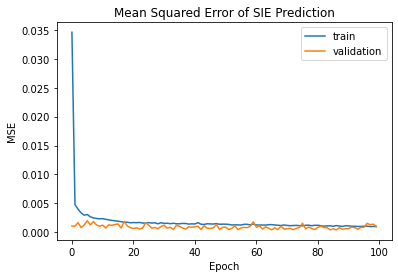

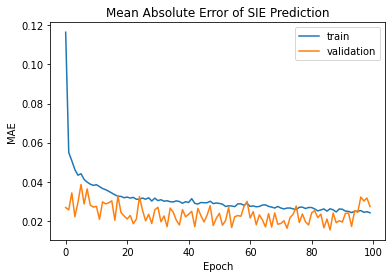

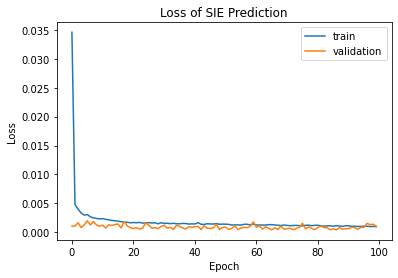

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

46/46 [==============================] - 1s 3ms/step


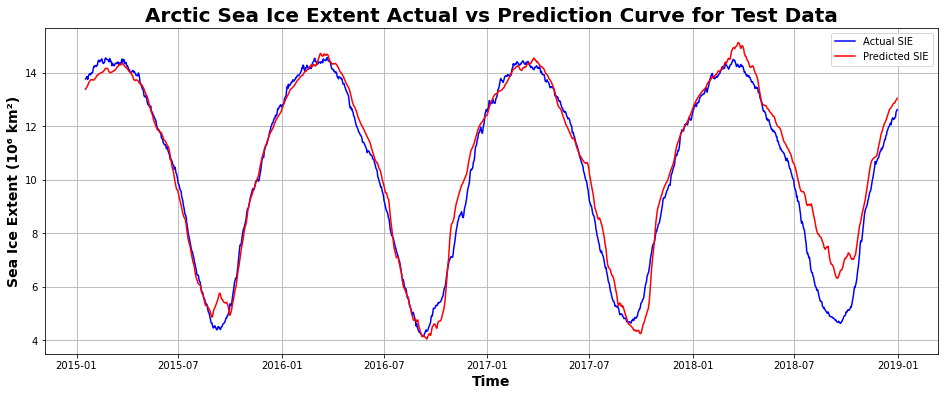

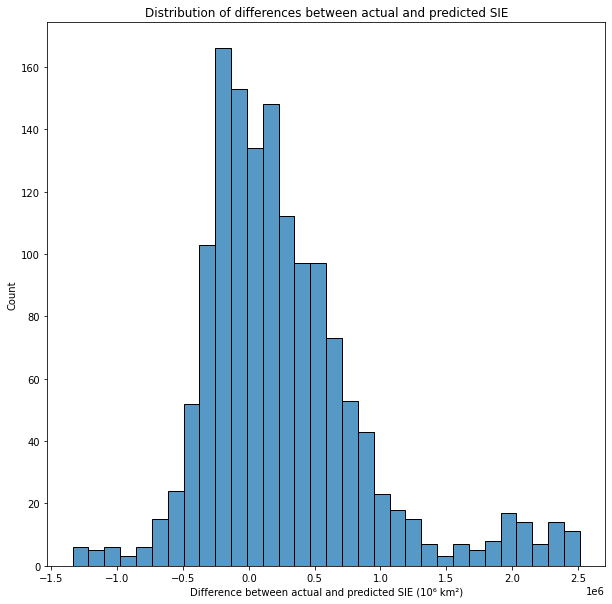

MSE :  470035401681.4836 (10⁶ km²)
MSPE : 1.2915646666124592 %
RMSE :  685591.2788837702 (10⁶ km²)
RMSPE : 11.364702664885074 %
MAE :  469270.4275086505 (10⁶ km²)
MAPE :  5.593256050620924 %
R2 :  0.9553458893245625


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass